#Air Quality in Particular Location

##Project Abstract:

Use air quality data http://www3.epa.gov/airdata/ad_data.html (Links to an external site.) and bring the factors that are contributing in  a particular geo location. 

##Procedures

1, Download data and add dataset to Object Storage

2, Clean and Select data

    2.1 split data
    
    2.2 map data
    
    2.3 find data you need
    
3, Analyse your data and get a conclusion


##Load Data

The data I use is download in http://www3.epa.gov/airdata/ad_data.html, it's an annual summary of 2015 of the whole country, the dataset name is *annual_all_2015.csv*

In [43]:
def set_hadoop_config(credentials):
    prefix = "fs.swift.service." + credentials['name'] 
    hconf = sc._jsc.hadoopConfiguration()
    hconf.set(prefix + ".auth.url", credentials['auth_url']+'/v2.0/tokens')
    hconf.set(prefix + ".auth.endpoint.prefix", "endpoints")
    hconf.set(prefix + ".tenant", credentials['project_id'])
    hconf.set(prefix + ".username", credentials['user_id'])
    hconf.set(prefix + ".password", credentials['password'])
    hconf.setInt(prefix + ".http.port", 8080)
    hconf.set(prefix + ".region", credentials['region'])
    hconf.setBoolean(prefix + ".public", True)

In [44]:
credentials = {}
credentials['name'] = 'keyfactor'
credentials['auth_url'] = 'https://identity.open.softlayer.com'
credentials['project_id'] = 'e6a01c4a648a4e20a1db088ee16b54c8'
credentials['region'] = 'dallas'
credentials['user_id'] = 'eeb49d62fd6a4fbd8930762fe3e81297'
credentials['password'] = 'Rad..UiEk^o}=8.0'

In [45]:
set_hadoop_config(credentials)


With the data file stored in Object Storage, we can now access it using the configured 
SparkContext in our notebook.


In [46]:
air_quality = sc.textFile("swift://notebooks.keyfactor/annual_all_2015.csv")

In [47]:
print "Total records in the annual_all_2015.csv dataset:", air_quality.count()

Total records in the annual_all_2015.csv dataset: 43454


In [48]:
print "The first row in the annual_all_2015.csv dataset:\n", air_quality.first()

The first row in the annual_all_2015.csv dataset:
"State Code","County Code","Site Num","Parameter Code","POC","Latitude","Longitude","Datum","Parameter Name","Sample Duration","Pollutant Standard","Metric Used","Method Name","Year","Units of Measure","Event Type","Observation Count","Observation Percent","Completeness Indicator","Valid Day Count","Required Day Count","Exceptional Data Count","Null Data Count","Primary Exceedance Count","Secondary Exceedance Count","Certification Indicator","Num Obs Below MDL","Arithmetic Mean","Arithmetic Standard Dev","1st Max Value","1st Max DateTime","2nd Max Value","2nd Max DateTime","3rd Max Value","3rd Max DateTime","4th Max Value","4th Max DateTime","1st Max Non Overlapping Value","1st NO Max DateTime","2nd Max Non Overlapping Value","2nd NO Max DateTime","99th Percentile","98th Percentile","95th Percentile","90th Percentile","75th Percentile","50th Percentile","10th Percentile","Local Site Name","Address","State Name","County Name","City Name"

##Parse Data

Now we have loaded the data and can access to it, the next step is to split the file by comma so that to parse data.


In [49]:
aqParse = air_quality.map(lambda line : line.split(","))

In [50]:
str(aqParse.collect()[85][-4])

'"Birmingham"'

In [51]:
print "It's an example of the splited data:\n", aqParse.first()

It's an example of the splited data:
[u'"State Code"', u'"County Code"', u'"Site Num"', u'"Parameter Code"', u'"POC"', u'"Latitude"', u'"Longitude"', u'"Datum"', u'"Parameter Name"', u'"Sample Duration"', u'"Pollutant Standard"', u'"Metric Used"', u'"Method Name"', u'"Year"', u'"Units of Measure"', u'"Event Type"', u'"Observation Count"', u'"Observation Percent"', u'"Completeness Indicator"', u'"Valid Day Count"', u'"Required Day Count"', u'"Exceptional Data Count"', u'"Null Data Count"', u'"Primary Exceedance Count"', u'"Secondary Exceedance Count"', u'"Certification Indicator"', u'"Num Obs Below MDL"', u'"Arithmetic Mean"', u'"Arithmetic Standard Dev"', u'"1st Max Value"', u'"1st Max DateTime"', u'"2nd Max Value"', u'"2nd Max DateTime"', u'"3rd Max Value"', u'"3rd Max DateTime"', u'"4th Max Value"', u'"4th Max DateTime"', u'"1st Max Non Overlapping Value"', u'"1st NO Max DateTime"', u'"2nd Max Non Overlapping Value"', u'"2nd NO Max DateTime"', u'"99th Percentile"', u'"98th Percentile

##Explore Data

Now we can start to clean and select the data we want.

**1. List all cities in the dataset, then user can choose the city he wants to analyse.**


In [52]:
print "Here are the city list you can look up!"
cities = set()
cities_d = aqParse.map(lambda x : str(x[-4])).collect()
for each in cities_d:
    cities.add(each)
for city in cities:
    print city

Here are the city list you can look up!
"Morro Bay"
"Fort Myers"
"Lower Grand Lagoon"
"Savannah"
"Lewes"
"Woodland"
"Duchesne"
"Jenison"
"Amherst"
"Cayce"
"Corvallis"
"Herculaneum"
"Boulder"
"San Pablo"
"Sacaton"
"Fort Pierce"
"Mason"
"Theodore"
"Groton"
"Sault Ste. Marie"
"Keokuk"
"McAlester"
"Big Horn"
"Warrensville Heights"
"Pilot Point"
"Carson City"
"Jackson"
"Escondido"
"Columbus (Remainder)"
"Harrison Township"
"Tupelo"
"Chicago"
"Monroe"
"Madison"
"Melbourne"
"Las Cruces"
"Delray Beach"
"Herriman"
"Holiday"
"San Rafael"
"Bend"
"Red Bluff"
"Brownsville"
"Allentown"
"Somerset"
"Conroe"
"Moundsville"
"Whiteriver"
"Taos"
"Mount Joy"
"Church Rock"
"Seattle"
"Tarpon Springs"
"Daytona Beach"
"Kansas City"
"Clinton"
"Cleves"
"New Albany"
"Manistee"
"Greenville"
"Greater Upper Marlboro"
"Bangor"
"Park Hill"
"Dunkirk"
"Great Falls"
"Harney"
"Fishers (corporate name for Fishers Station)"
"Summit"
"York"
"Omaha"
"Greensboro"
"Lawrence (Township of)"
"Killeen"
"Hartford"
"Bensley"
"La Grand

In [53]:
city = str(raw_input("Please select the city you need to analyse:  "))

Please select the city you need to analyse:  Denver


In [54]:
city

'Denver'

**2. If the city is found in the dataset, then begin extract data. If not, the user will get an error message.**


In [55]:
if city in str(aqParse.collect()):
    aqLoc = aqParse.filter(lambda x: str(x[-4]) == ('"' + city + '"'))
    print "City is found! Ready to analyse!"
else:
    print "Sorry, the city is not found!" 

City is found! Ready to analyse!


In [56]:
print "All data of the city %s:\n"%city, aqLoc.collect()

All data of the city Denver:
[[u'"08"', u'"031"', u'"0002"', u'"42101"', u'2', u'39.751184', u'-104.987625', u'"WGS84"', u'"Carbon monoxide"', u'"1 HOUR"', u'"CO 1-hour 1971"', u'"Obseved hourly values"', u'"INSTRUMENTAL - NONDISPERSIVE INFRARED"', u'2015', u'"Parts per million"', u'"No Events"', u'2870', u'33', u'"N"', u'120', u'365', u'0', u'10', u'0', u'0', u'"Certification not required"', u'2189', u'0.366742', u'0.262365', u'2.8', u'"2015-01-05 12:00"', u'2.5', u'"2015-01-05 09:00"', u'2.5', u'"2015-01-05 11:00"', u'2.5', u'"2015-02-06 17:00"', u'""', u'""', u'""', u'""', u'1.4', u'1.2', u'0.9', u'0.7', u'0.25', u'0.25', u'0.25', u'"DENVER - CAMP"', u'"2105 BROADWAY"', u'"Colorado"', u'"Denver"', u'"Denver"', u'"Denver-Aurora', u' CO"', u'"2015-06-11"'], [u'"08"', u'"031"', u'"0002"', u'"42101"', u'2', u'39.751184', u'-104.987625', u'"WGS84"', u'"Carbon monoxide"', u'"8-HR RUN AVG END HOUR"', u'"CO 8-hour 1971"', u'"8-Hour running average (end hour) of observed hourly values"', u'"

**3. Clean and select the data we need about the city, here we select all parameters and their max values, then we can do map reduce to process data.**


In [57]:
# x[8] is the parameter name
# x[29] is the 1st max value
aqParam = aqLoc.map(lambda x : (str(x[8]), (float(x[29]),1)))

In [58]:
# from operator import add
# aqAddByKey = aqParam.reduceByKey(add).sortByKey()
aqAddByKey = aqParam.reduceByKey(lambda v1,v2 : list((v1[0]+v2[0], v1[1]+v2[1]))).sortByKey()

In [59]:
aqAddByKey.first()

('"Ambient Temperature"', [57.900000000000006, 3])

***Another way to do reducebykey -- using group function***

aqGroupParam = map(lambda (x,y) : (x, list(y)), sorted(aqParam.groupByKey().collect()))

aqGroupParam[0]


##Analyse Data

In order to find the factors contribute to the air quality in a particular location, we **find out the average value of each air parameter's max value**, then we **select the top 10 parameters** and assume these parameters are factors we want. 

If the location doesn't have 10 parameters, we just show all the parameters it has.


In [60]:
aqAverages = aqAddByKey.map(lambda k: (k[0], k[1][0] / float(k[1][1] ) ) )

In [61]:
aqAverages.collect()

[('"Ambient Temperature"', 19.3),
 ('"Carbon monoxide"', 2.4275),
 ('"Elapsed Sample Time"', 1440.0),
 ('"Nitric oxide (NO)"', 432.4),
 ('"Nitrogen dioxide (NO2)"', 88.0),
 ('"Outdoor Temperature"', 81.0),
 ('"Oxides of nitrogen (NOx)"', 519.9),
 ('"Ozone"', 0.056333333333333326),
 ('"PM10 - LC"', 125.1),
 ('"PM10 Total 0-10um STP"', 53.0),
 ('"PM2.5 - Local Conditions"', 37.56818181818182),
 ('"PM2.5 Total Atmospheric"', 55.449999999999996),
 ('"SO2 max 5-min avg"', 91.0),
 ('"Sample Baro Pressure"', 639.6666666666666),
 ('"Sample Flow Rate- CV"', 0.3666666666666667),
 ('"Sample Volume"', 24.0),
 ('"Std Dev Hz Wind Direction"', 93.19999999999999),
 ('"Sulfur dioxide"', 10.5),
 ('"Wind Direction - Resultant"', 359.85),
 ('"Wind Direction - Scalar"', 360.0),
 ('"Wind Speed - Resultant"', 13.05),
 ('"Wind Speed - Scalar"', 13.8)]

In [65]:
valueTop10=[]
paramTop10=[]
print "Factors contributing to air quality in %s:\n"%city
for pair in aqAverages.map(lambda (x,y) : (y,x)).top(10):
    valueTop10.append(pair[0])
    paramTop10.append(pair[1])
    print "Air Quality Parameter %s had average Max Value of %f" % (pair[1],pair[0])

Factors contributing to air quality in Denver:

Air Quality Parameter "Elapsed Sample Time" had average Max Value of 1440.000000
Air Quality Parameter "Sample Baro Pressure" had average Max Value of 639.666667
Air Quality Parameter "Oxides of nitrogen (NOx)" had average Max Value of 519.900000
Air Quality Parameter "Nitric oxide (NO)" had average Max Value of 432.400000
Air Quality Parameter "Wind Direction - Scalar" had average Max Value of 360.000000
Air Quality Parameter "Wind Direction - Resultant" had average Max Value of 359.850000
Air Quality Parameter "PM10 - LC" had average Max Value of 125.100000
Air Quality Parameter "Std Dev Hz Wind Direction" had average Max Value of 93.200000
Air Quality Parameter "SO2 max 5-min avg" had average Max Value of 91.000000
Air Quality Parameter "Nitrogen dioxide (NO2)" had average Max Value of 88.000000


**Finally, use a bar chart to clearly show the resaults.**

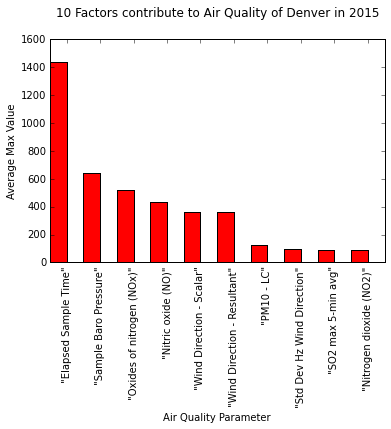

In [66]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

N = len(valueTop10)
index = np.arange(N)  
bar_width = 0.5

plt.bar(index, valueTop10, bar_width,
                 color='r')
plt.xlabel('Air Quality Parameter')
plt.ylabel('Average Max Value')
plt.title(str(N) + ' Factors contribute to Air Quality of ' + city + ' in 2015', y=1.08)
plt.xticks(index + bar_width, paramTop10, rotation=90, horizontalalignment = 'center')
plt.show()